In [14]:
import numpy as np 
import matplotlib.pyplot as plt

In [15]:
# Galerkin Basis functions
def phi(x_i,z_i,x_j,z_j,a):
    eps = 1e-6
    r = np.sqrt((x_i-x_j)**2 + (z_i-z_j)**2)
    
    return np.exp(-(a*r)**2)

def nabla2(xi,zi,xj,zj,a):
    eps = 1e-6
    return 4*a**2*(a**2*(xi - xj)**2 + a**2*(zi - zj)**2 - 1)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def dphidx(xi,zi,xj,zj,a):
    return 2*a**2*(-xi + xj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def dphidz(xi,zi,xj,zj,a):
    return 2*a**2*(-zi + zj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def d2phidx2(xi,zi,xj,zj,a):
    return a**2*(4*a**2*(xi - xj)**2 - 2)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def d2phidz2(xi,zi,xj,zj,a):
    return a**2*(4*a**2*(zi - zj)**2 - 2)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def d2phidxdz(xi,zi,xj,zj,a):
    return 4*a**4*(xi - xj)*(zi - zj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))





In [16]:
#numerical parameters
pi = 3.14159
dx = 0.1
a = 1/(5*dx) #fitting parameter for galerkin functions
g = 1.0
tilt_angle = pi/4
alpha = tilt_angle

In [17]:
#building grid:



#the buffer regions help with minimising oscillations around edges of the grid
N_buff = 2
xbuffer,zbuffer = np.meshgrid(np.arange(-dx*N_buff,2+dx*(N_buff+1),dx),np.arange(-dx*N_buff,1+dx*N_buff+dx*0.5,dx))

#total number of points in the grid including buffer points
nx_tot =xbuffer.shape[0]
nz_tot = zbuffer.shape[1]

#setting up the four buffer regions
Xbuffer1 = xbuffer[:,0:N_buff].reshape((nx_tot*N_buff,1))
Xbuffer2 = xbuffer[-N_buff:,N_buff:].reshape(((nz_tot-N_buff)*N_buff,1))
Xbuffer3 = xbuffer[0:N_buff,N_buff:].reshape(((nz_tot-N_buff)*N_buff,1))
Xbuffer4 = xbuffer[N_buff:-N_buff,-N_buff:].reshape(((nx_tot-2*N_buff)*N_buff,1))
Xbuffer = np.concatenate((Xbuffer1,Xbuffer2,Xbuffer3,Xbuffer4))
Zbuffer1 = zbuffer[:,0:N_buff].reshape((nx_tot*N_buff,1))
Zbuffer2 = zbuffer[-N_buff:,N_buff:].reshape(((nz_tot-N_buff)*N_buff,1))
Zbuffer3 = zbuffer[0:N_buff,N_buff:].reshape(((nz_tot-N_buff)*N_buff,1))
Zbuffer4 = zbuffer[N_buff:-N_buff,-N_buff:].reshape(((nx_tot-2*N_buff)*N_buff,1))
Zbuffer = np.concatenate((Zbuffer1,Zbuffer2,Zbuffer3,Zbuffer4))

N_buffer = Xbuffer.shape[0] #number of points only within the buffer regions, not in the main solution domain


#interior points
x,z = np.meshgrid(np.arange(0,2+dx,dx),np.arange(0,1+dx,dx))
n = x.shape[0]
m = x.shape[1]

ni = n-2
mi = m-2
xi = x[1:-1,1:-1].reshape((ni*mi,1))
zi = z[1:-1,1:-1].reshape((ni*mi,1))

#finding points along the boundary of the domain (excluding buffer zones)
xo = np.zeros((n*2 + 2*(m-2),1))
zo = np.zeros((n*2 + 2*(m-2),1))
No = n*2 + 2*(m-2)
xo[0:n,0] = x[:,0]
zo[0:n,0] = z[:,0]
xo[n:n+m-2,0] = x[-1,1:-1]
zo[n:n+m-2,0] = z[-1,1:-1]
xo[n+m-2:2*n+m-2,0] = np.flipud(x[:,-1])
zo[n+m-2:2*n+m-2,0] = np.flipud(z[:,-1])
xo[2*n+m-2:,0] = np.flipud(x[0,1:-1])
zo[2*n+m-2:,0] = np.flipud(z[0,1:-1])

#combined interior points xi, boundary points xo and buffer points Xbuffer:
Xtot = np.concatenate((xi,xo,Xbuffer)) -1
Ztot = np.concatenate((zi,zo,Zbuffer)) -1


#plt.plot(Xtot,Ztot,'.')

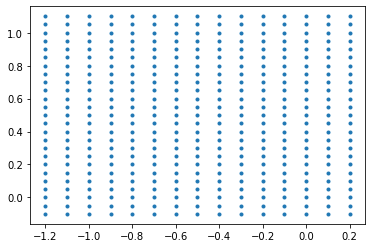

In [18]:
#transforming domain into a circle

r = np.maximum(np.abs(Xtot),np.abs(Ztot))
theta = np.arctan2(Ztot,Xtot)
Xtot_copy = (Xtot +0 -1)/2
Ztot_copy = Ztot + 0
#Xtot = r*np.cos(theta)
#Ztot = r*np.sin(theta)
Xtot = Ztot_copy + 0
#Ztot = -np.sign(Xtot_copy)*(np.abs(Xtot_copy))**(1/2) + 0
Ztot = -Xtot_copy + 0
#redefining sets of points with circle geometry

#interior
Xi = Xtot[0:ni*mi,:]
Zi = Ztot[0:ni*mi,:]

#exterior
Xo = Xtot[ni*mi:ni*mi+No,:]
Zo = Ztot[ni*mi:ni*mi+No,:]

#interior + exterior combined:

Xc = Xtot[0:ni*mi+No,:]
Zc = Ztot[0:ni*mi+No,:]

#buffer
Xb = Xtot[ni*mi+No:,:]
Zb = Ztot[ni*mi+No:,:]

plt.plot(Xtot,Ztot,'.')


<ipython-input-19-599192ae17fc>:15: RuntimeWarning: invalid value encountered in sqrt
  dudz = (g*np.sin(alpha))**0.5*(1-Ztot)**0.5 + noise_param*np.random.randn(nx_tot*nz_tot,1)**2
<ipython-input-19-599192ae17fc>:16: RuntimeWarning: divide by zero encountered in power
  d2udz2 = -0.5*(g*np.sin(alpha))**0.5*(1-Ztot)**(-0.5) - noise_param*np.random.randn(nx_tot*nz_tot,1)**2
<ipython-input-19-599192ae17fc>:16: RuntimeWarning: invalid value encountered in power
  d2udz2 = -0.5*(g*np.sin(alpha))**0.5*(1-Ztot)**(-0.5) - noise_param*np.random.randn(nx_tot*nz_tot,1)**2


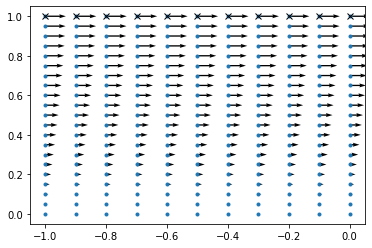

In [19]:
#importing velocity field
u_test = np.cos(pi*Xtot/2)
v_test = Ztot*np.sin(pi*Xtot/2)*pi/2

#Nusselt Solution
#u_test = 2*(Ztot+1) - (Ztot+1)**2
u_test = 2*Ztot - Ztot**2
v_test = Ztot*0

#Power law solution for K = 1 and n = 2
#2*(g*np.sin(alpha))**0.5*

noise_param = 0.01
u_test = 2*(g*np.sin(alpha))**0.5*(1-np.sqrt(np.abs(1-Ztot))**(3))/3 + noise_param*np.random.randn(nx_tot*nz_tot,1)**2
dudz = (g*np.sin(alpha))**0.5*(1-Ztot)**0.5 + noise_param*np.random.randn(nx_tot*nz_tot,1)**2
d2udz2 = -0.5*(g*np.sin(alpha))**0.5*(1-Ztot)**(-0.5) - noise_param*np.random.randn(nx_tot*nz_tot,1)**2
d2udz2[np.abs(d2udz2)>1000] = -10000000

dudz = dudz[0:n*m,:]
d2udz2 = d2udz2[0:n*m,:]

#u_test[np.isnan(u_test)] = 2*(g*np.sin(alpha))**0.5/3
#u_test = Ztot-Ztot**2 + Ztot**3/3
#finding relevent derivative fields:

a = 1/(3*dx)
N = Xtot.shape[0]
phi_u = np.zeros((N,N))
nabla2_phi_u = np.zeros((N,N))
dphi_u_dx = np.zeros((N,N))
dphi_u_dz = np.zeros((N,N))
d2phi_u_dx2 = np.zeros((N,N))
d2phi_u_dz2 = np.zeros((N,N))
d2phi_u_dxdz = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        phi_u[i,j] = phi(Xtot[i,0],Ztot[i,0],Xtot[j,0],Ztot[j,0],a)
        nabla2_phi_u[i,j] = nabla2(Xtot[i,0],Ztot[i,0],Xtot[j,0],Ztot[j,0],a)
        dphi_u_dx[i,j] = dphidx(Xtot[i,0],Ztot[i,0],Xtot[j,0],Ztot[j,0],a)
        dphi_u_dz[i,j] = dphidz(Xtot[i,0],Ztot[i,0],Xtot[j,0],Ztot[j,0],a)
        d2phi_u_dx2[i,j]  = d2phidx2(Xtot[i,0],Ztot[i,0],Xtot[j,0],Ztot[j,0],a)
        d2phi_u_dz2[i,j]  = d2phidz2(Xtot[i,0],Ztot[i,0],Xtot[j,0],Ztot[j,0],a)
        d2phi_u_dxdz[i,j]  = d2phidxdz(Xtot[i,0],Ztot[i,0],Xtot[j,0],Ztot[j,0],a)


u_j = np.linalg.solve(phi_u,u_test)
v_j = np.linalg.solve(phi_u,v_test)

nabla2_u = np.matmul(nabla2_phi_u,u_j)[0:n*m,:]
nabla2_v = np.matmul(nabla2_phi_u,v_j)[0:n*m,:]*0
dudx = np.matmul(dphi_u_dx,u_j)[0:n*m,:]*0

dvdx = np.matmul(dphi_u_dx,v_j)[0:n*m,:]*0
dvdz = np.matmul(dphi_u_dz,v_j)[0:n*m,:]*0
d2udx2 = np.matmul(d2phi_u_dx2,u_j)[0:n*m,:]*0

d2udxdz = np.matmul(d2phi_u_dxdz,u_j)[0:n*m,:]*0
d2vdx2 = np.matmul(d2phi_u_dx2,v_j)[0:n*m,:]*0
d2vdz2 = np.matmul(d2phi_u_dz2,v_j)[0:n*m,:]*0
d2vdxdz = np.matmul(d2phi_u_dxdz,v_j)[0:n*m,:]*0



#d2udz2[Ztot[0:n*m,:]>0.99] = -1000
dudz[Ztot[0:n*m,:]>0.99] = 0
#plt.plot(Xi,Zi,'.')
#plt.plot(Xo,Zo,'.',color='r')
#plt.plot(Xb,Zb,'.',color = 'k')
#plt.plot(Xtot[0:n*m,:],Ztot[0:n*m,:],'.')
plt.plot(Xc,Zc,'.')
plt.plot(Xc[ni*mi:ni*mi+n],Zc[ni*mi:ni*mi+n],'x',color = 'k')
plt.quiver(Xtot[0:n*m,:],Ztot[0:n*m,:],u_test[0:n*m,:],v_test[0:n*m,:])
#plt.quiver(Xtot[0:n*m,:],Ztot[0:n*m,:],nabla2_u,v_test[0:n*m,:])

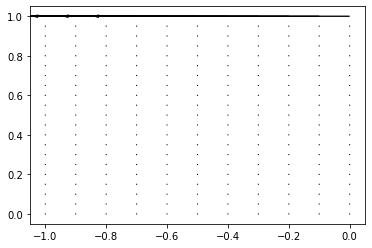

In [20]:
plt.quiver(Xtot[0:n*m,:],Ztot[0:n*m,:],d2udz2,v_test[0:n*m,:])


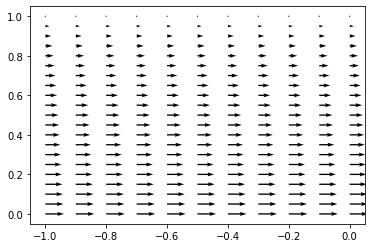

In [21]:
plt.quiver(Xtot[0:n*m,:],Ztot[0:n*m,:],dudz,v_test[0:n*m,:])
#print(u_test)
#print(u_test)

In [22]:
#building solution Galerkin matrices
gov_mat = np.zeros((2*n*m, 2*n*m))

#horizontal momentum
for i in range(0,m*n):
    for j in range(0,m*n):
        #gov_mat[i,j] = nabla2_u[i,0]*phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        gov_mat[i,j] = 2*dudx[i,0]*dphidx(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a) + 2*d2udx2[i,0]*phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a) + (dudz[i,0]+dvdx[i,0])*dphidz(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a)
        gov_mat[i,j] += phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a)*(d2udz2[i,0] + d2vdxdz[i,0])

        gov_mat[i,j+m*n] = -dphidx(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a)

#vertical momentum 
nabla2v = Xc*0 + 1
for i in range(0,m*n):
    for j in range(0,m*n):
        gov_mat[i+m*n,j] = nabla2_v[i,0]*phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        gov_mat[i+m*n,j+m*n] = -dphidz(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a)

#building inhomogeneous vector:

inhom_vect = np.zeros((2*n*m,1))
inhom_vect[0:n*m,0] =  -g*np.sin(tilt_angle)
inhom_vect[n*m:,0] = g*np.cos(tilt_angle)


#viscosity boundary condition:

gov_mat[ni*mi:ni*mi+n,:] = 0
inhom_vect[ni*mi:ni*mi+n,:] = 0

for i in range(ni*mi,ni*mi+n):
    for j in range(0,m*n):
        gov_mat[i,j] = phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)



In [23]:
#pressure boundary condition:

gov_mat[m*n+ni*mi:m*n+ni*mi+n,:] = 0
inhom_vect[m*n+ni*mi:m*n+ni*mi+n,:] = 0
#pressure boundary condition
for i in range(m*n+ni*mi,m*n+ni*mi+n):
    for j in range(m*n,2*m*n):
        gov_mat[i,j] = phi(Xc[i-m*n,0],Zc[i-m*n,0],Xc[j-m*n,0],Zc[j-m*n,0],a)
#plt.imshow(gov_mat)
q_j = np.linalg.solve(gov_mat,inhom_vect)
test = np.matmul(gov_mat,q_j)

#calculating pressure and viscous fields:

phi_q = np.zeros((2*n*m,2*n*m))
for i in range(0,m*n):
    for j in range(0,m*n):
        phi_q[i,j] = phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        phi_q[i+n*m,j+n*m] = phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)

q_i = np.matmul(phi_q,q_j)

#extracting vectors of viscosity and pressure

mu_i = q_i[0:n*m,:]
p_i = q_i[n*m:,:]

#plt.quiver(Xc,Zc,p_i,p_i*0)

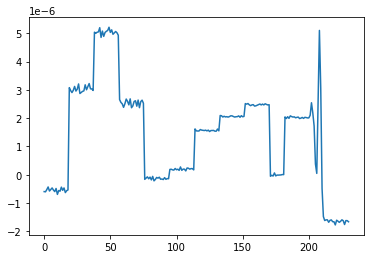

In [24]:
#comparing to hydrostatic pressure
plt.plot(p_i-g*(1-Zc)*np.cos(tilt_angle))

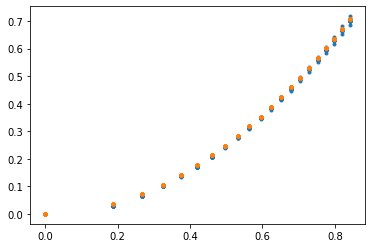

In [25]:
plt.plot(dudz[0:n*m,:],mu_i*dudz[0:n*m,:],'.')
plt.plot(dudz[0:n*m,:],dudz[0:n*m,:]*dudz[0:n*m,:],'.')

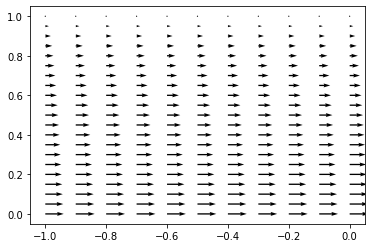

In [26]:
plt.quiver(Xtot[0:n*m,:],Ztot[0:n*m,:],mu_i,v_test[0:n*m,:])